# Building a Spam Filter with Naive Bayes


In this project, we will build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The goal is to write a program that classifies new messages as spam or non-spam (ham) with an accuracy greater than 80%. You can find the data set [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The data set was put together by Tiago A. Almeida and Jose Maria Gomez Hidalgo.

## Exploring the Data set

In [59]:
import pandas as pd
sms_spam = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

print(sms_spam.shape)
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [60]:
sms_spam['Label'].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

We can see that arpund 87% of the messages are non-spam and the remaining 13% are spam messages.

## Training and Test Set

We will split the data set into a training set and a test set, where the training set accounts for 80% of the data and 20% remaining data is left for the test set.

In [61]:
# randomize the dataset
data_randomized = sms_spam.sample(frac=1, random_state=1)

# calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# training and test split
training_set = data_randomized[:training_test_index].reset_index(drop=True) 
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [62]:
training_set['Label'].value_counts(normalize=True)*100

ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [63]:
test_set['Label'].value_counts(normalize=True)*100

ham     86.804309
spam    13.195691
Name: Label, dtype: float64

By analyzing percentages of spam and non-spam messages of both training and test sets, we can see that percentages are close to what we have in full data set. This is good! We then move to cleaning part.

## Data cleaning

To calculate all the probabilities required by the algorithm, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need. 

### Letter Case and Punctuation

In [64]:
training_set.head() # original data values

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [65]:
training_set['SMS'] = training_set['SMS'].str.lower()
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')
training_set.head() # after cleaning

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


### Creating the Vocabulary

We will create the vocabulary, which in this context means a list with all the unique words in our training set. 

In [66]:
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary))

In [67]:
len(vocabulary)

7783

There are 7783 unique words in all the messages of the training set.

### Final training set

In [68]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [69]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,angry,desparate,because,safely,uup,1120,avoid,thinked,smoothly,click,...,pack,second,uneventful,542,nike,69855,mumhas,5k,sue,music
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,Label,SMS,angry,desparate,because,safely,uup,1120,avoid,thinked,...,pack,second,uneventful,542,nike,69855,mumhas,5k,sue,music
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We are now done with data cleaning the training set, and we can move on creating the spam filter.

## Calculating Constants First

The Naive Bayes algorithm will need to answer these 2 probability questions to be able to classify new messages:

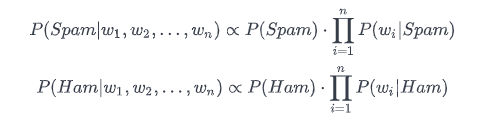

In addition to calculate P(wi|Spam) and P(wi|Ham) inside these 2 formulas, we'll need to use these equations:
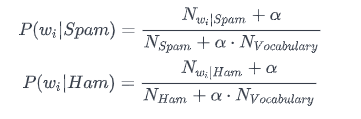

In [71]:
# isolating soam and ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

# N_Spam
n_words_per_spam_messages = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_messages.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters

Now that we have the constant terms calculated above, we can move on with calculating the parameters P(wi|Spam) and P(wi|Ham). Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:
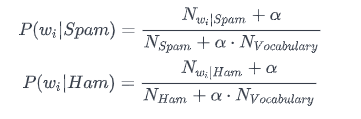

In [77]:
# initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha * n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha * n_vocabulary)
    parameters_ham[word] = p_word_given_ham
    

## Classifying a new message

Now when we have all the parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:
- Takes in as input a new message (w1, w2, ..., wn).
- Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn).
- Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
    - If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
    - If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
    - If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [78]:
import re

def classify(message):
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_messages = p_spam
    p_ham_given_messages = p_ham
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_messages *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_messages *= parameters_ham[word]
    
    print("P(Spam|messages):", p_spam_given_messages)
    print("P(Ham|messages):", p_ham_given_messages)
    
    if p_ham_given_messages > p_spam_given_messages:
        print('Label: Ham')
    elif p_ham_given_messages < p_spam_given_messages:
        print('Label: Spam')
    else:
        print("Equal probabilities, have a human classify this!")

In [79]:
classify('I need a break')

P(Spam|messages): 2.6566189907604666e-13
P(Ham|messages): 1.3878611656630023e-10
Label: Ham


## Measuring the Spam Filter's Accuracy

The result above looks promising, but to be sure, we will check the accuracy of the filter.

In [80]:
# write a function that returns classification labels instead of printing them
def classify_test_set(message):
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_messages = p_spam
    p_ham_given_messages = p_ham
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_messages *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_messages *= parameters_ham[word]
    
    if p_ham_given_messages > p_spam_given_messages:
        return 'ham'
    elif p_ham_given_messages < p_spam_given_messages:
        return 'spam'
    else:
        return 'needs human classification'

In [81]:
test_set['Predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,Predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now we'll write a function to measure the accuracy of the filter to see how well the filter does. 

In [82]:
correct = 0
total = test_set.shape[0]

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['Predicted']:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', (correct/total)*100)

Correct: 1100
Incorrect: 14
Accuracy: 98.74326750448833


The accuracy is 98.8%, which is really good. Our spam filter looked at 1,114 messages that it had not seen in training, and classified around 1,100 correctly. After succeedingly building the filter, we can jump to:
- Analyze 14 messages that were classified incorrectly and try to figure out why the algorithm classified them incorrectly.
- Make the filtering process more complex by making the algorithm sensitive to letter case. 